# IV. Zonal statistics, spectral signatures and vegetation index

---
**Author(s):** Quentin Yeche, Kenji Ose, Dino Ienco - [UMR TETIS](https://umr-tetis.fr) / [INRAE](https://www.inrae.fr/)

---

## 1. Introduction

Here are presented two solutions for computing zonal statistics on Sentinel-2 image with polygon vector file. We will try two librairies : `xrspatial` and `rasterstats`.

## 2. Import libraries

As usual, we import all the required Python libraries.

In [1]:
# STAC access
import pystac_client
import planetary_computer

# (geo)dataframes
import pandas as pd
import geopandas as gpd

# xarrays
import rioxarray
import xarray as xr

from rasterio import features

# library for turning STAC objects into xarrays
import stackstac

# visualization
from matplotlib import pyplot as plt

# miscellanous
import numpy as np
from IPython.display import display

## 3. Creating a `DataArray` from STAC object

### 3.1. Getting a Sentinel-2 STAC Item 

As a practical use case let's consider that we have identified the STAC Item we're interested in (see [this notebook](Joensuu_01-STAC.ipynb) for a refresher), and we also have an area of interest defined as a bounding box.

In [2]:
# Access to Planetary Computer API
root_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

item_id = 'S2A_MSIL2A_20201213T104441_R008_T31TEJ_20201214T083443'
item = root_catalog.get_collection("sentinel-2-l2a").get_item(item_id)

### 3.2. Loading Sentinel-2 image

We stack the item's assest, corresponding to spectral bands, into a `rioxarray` with a resampling at a spatial resolution of 10m.

we also collect information that will be useful for the following processing steps.

In [3]:
# bounding box expressed in Lat/Lon
aoi_bounds = (3.875107329166124, 43.48641456618909, 4.118824575734205, 43.71739887308995)

# bands of interest
boi = ['B02','B03','B04','B05','B06','B07','B08','B11','B12']

FILL_VALUE = 2**16-1

ds = stackstac.stack(
                item,
                assets = boi,
                resolution=10,
                dtype="uint16",
                fill_value=FILL_VALUE,
                bounds_latlon=aoi_bounds,
                    )

s2_ref_crs = ds.crs
s2_ref_trf = ds.transform
s2_ref_shape = (ds['x'].size, ds['y'].size)

print(f'- S2 CRS: {s2_ref_crs}')
print(f'- S2 affine transform: \n{s2_ref_trf}')
print(f'- S2 XY dimension: {s2_ref_shape}')

- S2 CRS: epsg:32631
- S2 affine transform: 
| 10.00, 0.00, 570490.00|
| 0.00,-10.00, 4841100.00|
| 0.00, 0.00, 1.00|
- S2 XY dimension: (1999, 2590)


/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


## 4. Loading of polygon vector file

### 4.1. Conversion into data array

In order to compute zonal statistics, first we have to convert the file into a labeled raster. Labels must be of integer type.

The vector file, named `sample.geojson`, has an attribute table with the following information:
- **fid**: unique ID [integer]
- **geometry**: coordinates of entity's polygon <[list]
- **landcover**: label [string]

In [4]:
field = gpd.read_file('sample.geojson')
field_to_raster_crs = field.to_crs(s2_ref_crs)
geom = field_to_raster_crs[['geometry', 'fid']].values.tolist()

field_cropped_raster = features.rasterize(geom, out_shape=s2_ref_shape, fill=0, transform=s2_ref_trf)
field_cropped_raster_xarr = xr.DataArray(field_cropped_raster)

### 4.2. Displaying the labeled image

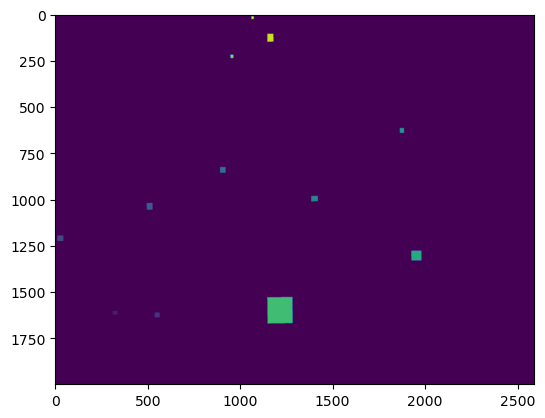

In [5]:
import matplotlib.pyplot as plt

plt.imshow(field_cropped_raster_xarr)

## 5. Computing of zonal statistics 

### 5.1. Solution 1: with `xrspatial`

Here, we compute statistics based on each Sentinel-2 bands and merge the results into the vector file attribute table.

#### 5.1.1. Creating a dedicated function

First, we create a function, named `s2_zonal`, that calls `xrspatial.zonal_stats`.

In [6]:
from xrspatial import zonal_stats as xrspatial_zs
import time

def s2_zonal(ds, band, field_cropped_raster_xarr):
    s2_band = ds.sel(band=band).squeeze('time').values
    s2_band = s2_band.T
    s2_band_xarr = xr.DataArray(s2_band)
    sign_spectral = xrspatial_zs(field_cropped_raster_xarr, 
                                 s2_band_xarr, 
                                 stats_funcs = ['count','min','mean','max'], nodata_values = 0)
    
    out_names = dict()
    for i in sign_spectral.columns:
        out_names[i] = '{}_{}'.format(band, i)
    sign_spectral.rename(columns = out_names, inplace = True)

    return sign_spectral


#### 5.1.2. Calculating summary statistics of each vector entity

In [7]:
final = field.copy()

start_time = time.time()

for band in boi:
    df = s2_zonal(ds, band, field_cropped_raster_xarr)
    final = final.merge(df, left_on='fid', right_on='{}_zone'.format(band))
end_time = time.time()

duration = (end_time - start_time)
minutes, seconds =  divmod(duration, 60)
print(f'duration: {int(minutes)} min {seconds:.2f} sec')

duration: 0 min 6.34 sec


#### 5.1.3. Displaying head of output table

In [8]:
cols = [c for c in final.columns if c.lower()[3:] != '_zone']
finalb = final[cols]
finalb.head()

,fid,landcover,geometry,B02_count,B02_min,B02_mean,B02_max,B03_count,B03_min,B03_mean,...,B08_mean,B08_max,B11_count,B11_min,B11_mean,B11_max,B12_count,B12_min,B12_mean,B12_max
0,1,urban01,"POLYGON ((3.91165 43.57305, 3.91165 43.57490, ...",531.0,2388.0,4287.201507,6660.0,531.0,2508.0,4328.169492,...,5698.647834,7708.0,531.0,3607.0,4689.148776,6028.0,531.0,2839.0,3689.853107,4747.0
1,2,urban02,"POLYGON ((3.93971 43.57152, 3.93971 43.57383, ...",693.0,634.0,1241.432900,2182.0,693.0,952.0,1536.844156,...,3583.160173,5324.0,693.0,2283.0,2936.402597,3363.0,693.0,1305.0,2091.681097,2555.0
2,3,urban03,"POLYGON ((3.87511 43.60920, 3.87511 43.61179, ...",928.0,443.0,1138.025862,1808.0,928.0,625.0,1301.089440,...,2687.463362,3574.0,928.0,1692.0,2254.778017,2932.0,928.0,1305.0,1772.153017,2372.0
3,4,baresoil01,"POLYGON ((3.93528 43.62391, 3.93528 43.62714, ...",1097.0,33.0,209.622607,2126.0,1097.0,4.0,393.457612,...,2458.596171,5240.0,1097.0,875.0,1402.441203,2884.0,1097.0,417.0,692.770283,1546.0
4,5,baresoil02,"POLYGON ((3.98472 43.64148, 3.98472 43.64420, ...",874.0,96.0,598.306636,3746.0,874.0,220.0,878.553776,...,2204.616705,4062.0,874.0,963.0,2158.538902,3169.0,874.0,628.0,1615.618993,3038.0


### 5.2 Solution 2: with `rasterstats`

#### 5.2.1. Installation of `rasterstats` library

Here, we will use another package, named `rasterstats`. As it is not installed by default, we add it in our environment.

In [9]:
!pip install rasterstats

#### 5.2.2. Creating a dedicated function

First, we create a function, named `s2_zonal2`, that calls `rasterstats.zonal_stats`.

In [10]:
from rasterstats import zonal_stats as rasterstats_zs

def s2_zonal2(stac_item, band, geodf, geodf_id):
    fid = field_to_raster_crs[geodf_id]
    zs = rasterstats_zs(geodf, stac_item.assets[band].href, stats="count min mean max median")
    sign_spectral = pd.DataFrame(zs)
    sign_spectral = pd.concat([fid, sign_spectral], axis=1)
        
    out_names = dict()
    for i in sign_spectral.columns:
        out_names[i] = '{}_{}'.format(band, i)
    sign_spectral.rename(columns = out_names, inplace = True)

    return sign_spectral

#### 5.2.3. Calculating summary statistics of each vector entity

In [11]:
final2 = field.copy()

start_time = time.time()
for band in boi:
    df = s2_zonal2(item, band, field_to_raster_crs, "fid")
    final2 = final2.merge(df, left_on='fid', right_on='{}_fid'.format(band))
end_time = time.time()

duration = (end_time - start_time)
minutes, seconds =  divmod(duration, 60)
print(f'duration: {int(minutes)} min {seconds:.2f} sec')

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


duration: 0 min 4.89 sec


#### 5.2.4. Displaying head of output table

In [12]:
cols = [c for c in final2.columns if c.lower()[3:] != '_fid']
final2b = final2[cols]
final2b.head()

,fid,landcover,geometry,B02_min,B02_max,B02_mean,B02_count,B02_median,B03_min,B03_max,...,B11_min,B11_max,B11_mean,B11_count,B11_median,B12_min,B12_max,B12_mean,B12_count,B12_median
0,1,urban01,"POLYGON ((3.91165 43.57305, 3.91165 43.57490, ...",133.0,1640.0,703.994350,531,674.0,329.0,2076.0,...,1359.0,3290.0,2250.615385,130,2241.5,1089.0,2927.0,1887.169231,130,1875.5
1,2,urban02,"POLYGON ((3.93971 43.57152, 3.93971 43.57383, ...",277.0,3570.0,1802.806638,693,1676.0,293.0,4264.0,...,1116.0,3952.0,2583.041420,169,2621.0,923.0,3248.0,2152.218935,169,2251.0
2,3,urban03,"POLYGON ((3.87511 43.60920, 3.87511 43.61179, ...",70.0,2504.0,650.589440,928,645.5,181.0,3084.0,...,1144.0,3641.0,2701.084746,236,2811.0,892.0,3448.0,2527.161017,236,2632.5
3,4,baresoil01,"POLYGON ((3.93528 43.62391, 3.93528 43.62714, ...",77.0,1274.0,472.221513,1097,478.0,185.0,1730.0,...,1532.0,3173.0,2735.403774,265,2766.0,1017.0,2469.0,2024.713208,265,2045.0
4,5,baresoil02,"POLYGON ((3.98472 43.64148, 3.98472 43.64420, ...",202.0,604.0,343.122426,874,332.0,370.0,1023.0,...,1667.0,3150.0,2335.400000,225,2315.0,1166.0,2319.0,1694.342222,225,1682.0


## 6. Spectral signatures

Now we have the summary statistics for several landcover types, we can plot their spectral signatures.

(135,)


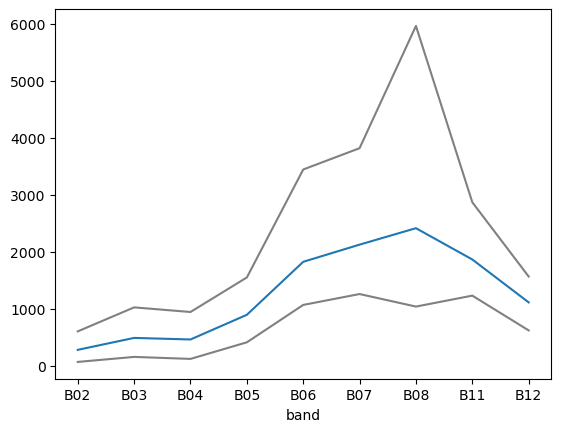

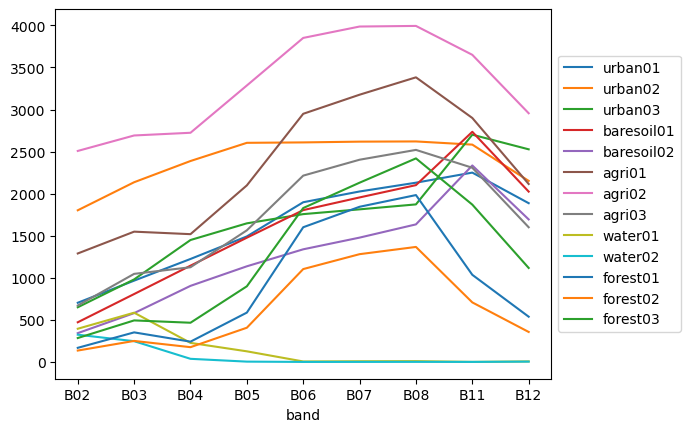

In [13]:
df_spectral = final2b.set_index('landcover').T
df_spectral = df_spectral.reset_index()

df_spectral['band'] = df_spectral['index'].str[:3]
df_spectral['stat'] = df_spectral['index'].str[4:]

df_spectral2 = df_spectral.set_index('band')
df_spectral2 = df_spectral2.drop(['fid', 'geo'])
df_spectral2 = df_spectral2.drop(['index'], axis=1)

test = pd.concat([df_spectral2.urban01, df_spectral2.urban02, df_spectral2.urban03])
print(test.shape)

#test2['radio'] = ['blue', 'green', 'red', 'rededge1', 'rededge2', 'rededge3', 'nir', 'swir1', 'swir2' ]

s2_mean = df_spectral2[df_spectral2['stat']=='mean'].drop(['stat'], axis=1)
s2_min = df_spectral2[df_spectral2['stat']=='min'].drop(['stat'], axis=1)
s2_max = df_spectral2[df_spectral2['stat']=='max'].drop(['stat'], axis=1)

ax = s2_mean['forest03'].plot()
s2_min['forest03'].plot(ax=ax, c='gray')
s2_max['forest03'].plot(ax=ax, c='gray')

ax = s2_mean.plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# 7. Band math and vegetation index 

## 7.1. NDVI principles

The NDVI (Normalized Difference Vegetation Index) is a vegetation index based on the difference between red and near infrared (nIR) values. Its formula is as follows:

$$NDVI = {nIR - Red \over nIR + Red}$$

This index exploits the spectral signature of the vegetation which is very particular, because it shows a very marked peak in the near infrared, and a lower reflectance in the red. This index is very effective in determining the presence of vegetation, but it can also be used to to evaluate the importance of the vegetation biomass as well as the intensity of the photosynthesis activity.

In [14]:
nir, red = ds.sel(band="B08").astype('float'), ds.sel(band="B04").astype('float')
ndvi = (nir-red)/(nir+red)

## 7.2. Plotting NDVI

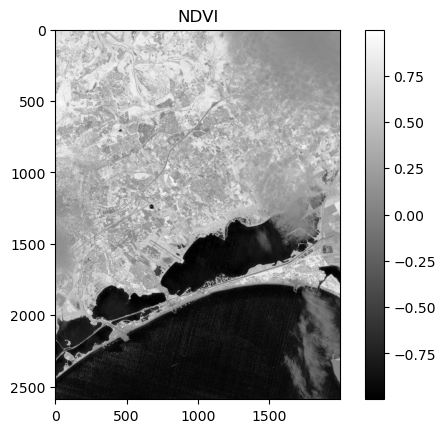

In [15]:
plt.imshow(ndvi.squeeze(), cmap="gray")#"RdYlGn")
plt.colorbar()
plt.title('NDVI')
plt.show()

### 7.3. Using of Jupyter widgets

It is possible to add elements (*slider*, *progress bar*, *checkbox*, *radio buttons*, etc.) to interact with the data visualization. To do this, load the `ipywidgets` library.

In [16]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def threshold(seuil):
    seuil = np.where(ndvi.squeeze()>seuil, 1, 0)
    plt.imshow(seuil, cmap="viridis", interpolation='nearest')#, cmap=plt.cm.gray)
    plt.colorbar()
    plt.show()

interact(threshold, seuil = widgets.FloatSlider(min=-1, max=1, step=0.001))

interactive(children=(FloatSlider(value=0.0, description='seuil', max=1.0, min=-1.0, step=0.001), Output()), _…

<function __main__.threshold(seuil)>